# Compute Moon and Venus Phase Angles with `astropy`

As an addition to the [Sun and Moon Altitudes](https://github.com/egemenimre/satstuff/blob/master/notebooks/astropy/Sun_Moon_Alt.ipynb) and [Sun Rise Set times](https://github.com/egemenimre/satstuff/blob/master/notebooks/astropy/sun_rise_set.ipynb), this notebook shows the steps to compute the [Phase Angles](https://en.wikipedia.org/wiki/Phase_angle_%28astronomy%29) for Moon and Venus.

Phase Angle defines the angle between the Sun, the Observed Object (e.g. Moon) and the Observer (you). Phase angle 0 for Moon corresponds to Full Moon (though actually you see a value close to, but not exactly equal to 0 degrees) and 180 deg corresponds to New Moon.   

The initial configuration of time and locations are similar to the [Sun and Moon Altitudes](https://github.com/egemenimre/satstuff/blob/master/notebooks/astropy/Sun_Moon_Alt.ipynb), so I will not go into detailed explanations. This time, though, the simulation duration is much longer and stepsizes are much larger, as the motion of the Moon is slow and that of Venus is even slower.

In [13]:
from astropy.coordinates import EarthLocation
from astropy import units as u
from astropy.time import Time, TimeDelta

import pytz

# Init location - default Ellipsoid is WGS84
istanbul: EarthLocation = EarthLocation(lat=41.015137, lon=28.979530, height=0 * u.m)
ist_timezone = pytz.timezone("Turkey")
utc_timezone = pytz.timezone("utc")
print(f"Target coordinates (lat,lon): {istanbul.lat}, {istanbul.lon}")

# Time analysis config (stepsize, duration, init time)
init_time: Time = Time("2020-04-01T00:00:00", scale="utc")
dt = TimeDelta(0.1, format="jd")  # stepsize
duration = TimeDelta(90.0, format="jd")  # duration

Target coordinates (lat,lon): 41.015137 deg, 28.979530000000004 deg


The next step is to set up the time steps and initialise the Sun, Moon and Venus vectors in [Geocentric Celestial Reference System (GCRS)](https://en.wikipedia.org/wiki/Barycentric_celestial_reference_system) i.e., an inertially fixed coordinate system with its centre at the Earth. This frame is fixed (not rotating) with respect to the stars. It is also what people usually mean when people talk about the [Earth Centred Inertial](https://en.wikipedia.org/wiki/Earth-centered_inertial) coordinate system. 

We also use these results in Cartesian form as they yield themselves well to the vector operations we will make later.

In [14]:
import numpy as np
from astropy.coordinates import get_moon, get_sun, get_body, SkyCoord

# Generate observation time list
dt_list = dt * np.arange(0, duration.sec / dt.sec, 1)
obs_times: Time = init_time + dt_list

# Generate Sun, Moon and Venus coordinates
sun_vec_gcrs: SkyCoord = get_sun(obs_times).cartesian
moon_vec_gcrs: SkyCoord = get_moon(obs_times).cartesian
venus_vec_gcrs: SkyCoord = get_body("venus", obs_times).cartesian

# Generate Earth location in GCRS
gnd_loc_gcrs = istanbul.get_gcrs(obs_times).cartesian.without_differentials()

Note that `get_body()` requires the name of the body that we are enquiring (in this case Venus). We can also call other planets similarly, and `get_moon()` uses this method under the hood.

Finally we have generated the GCRS coordinates of the location on ground. While whether we are looking at Venus from Istanbul or from the centre of the Earth makes scant difference, it does matter somewhat when we are looking at the Moon. We have also pruned the velocities, as the later vector operations do not need them (and actually do not like them).

For the next steps we are going to generate Sun-to-Moon and Ground-To-Moon vectors to find the Sun-Moon-Observer angle. In other words this how the Observer on the Ground sees the light falling on the Moon. We will then convert these vectors to unit vectors and get the arccosine of the dot product of these two - this is the basic procedure to compute the ["angle between vectors"](https://en.wikipedia.org/wiki/Dot_product#Geometric_definition):
\begin{equation*}
\mathbf {a} \cdot \mathbf {b} =\|\mathbf {a} \|\ \|\mathbf {b} \|\cos \theta
\end{equation*}

We apply the same procedure for Venus and finally print two sample values at the initial time. Note how we force the UTC timezone to force printing of the time zone information. 

In [15]:
from astropy.coordinates import CartesianRepresentation

# Generate Sun, Moon and Venus-to-Istanbul vectors
sun_to_moon: CartesianRepresentation = sun_vec_gcrs - moon_vec_gcrs
gnd_to_moon: CartesianRepresentation = gnd_loc_gcrs - moon_vec_gcrs

sun_to_venus: CartesianRepresentation = sun_vec_gcrs - venus_vec_gcrs
gnd_to_venus: CartesianRepresentation = gnd_loc_gcrs - venus_vec_gcrs

# Compute angle between two vectors for each instant in time
sun_to_moon_unit = sun_to_moon / sun_to_moon.norm()
gnd_to_moon_unit = gnd_to_moon / gnd_to_moon.norm()
phase_angle_moon = np.rad2deg(np.arccos(sun_to_moon_unit.dot(gnd_to_moon_unit)))

sun_to_venus_unit = sun_to_venus / sun_to_venus.norm()
gnd_to_venus_unit = gnd_to_venus / gnd_to_venus.norm()
phase_angle_venus = np.rad2deg(np.arccos(sun_to_venus_unit.dot(gnd_to_venus_unit)))

print(f"Moon phase angle  : {phase_angle_moon[0]} at {obs_times[0].to_datetime(timezone=utc_timezone)}")
print(f"Venus phase angle : {phase_angle_venus[0]} at {obs_times[0].to_datetime(timezone=utc_timezone)}")

Moon phase angle  : 95.59782267821191 deg at 2020-04-01 00:00:00+00:00
Venus phase angle : 93.30428615880972 deg at 2020-04-01 00:00:00+00:00


While the procedure above computes the phase angles for the entire duration, we might want to get the exact times for the Full Moon or the New Moon. While a proper interpolator is the right way to do this ([see this notebook](https://github.com/egemenimre/satstuff/blob/master/notebooks/astropy/sun_rise_set.ipynb) for a sample implementation), the phase angles change rather slowly even for Moon, and we will simply find the minimum of the Moon phase angles and call it the _approximate Full Moon_. To see how the Moon really looks like, you can use the excellent [NASA JPL Solar System Simulator](https://space.jpl.nasa.gov/) - I set up the result for [the Moon on 5 June 2020](https://space.jpl.nasa.gov/cgi-bin/wspace?tbody=301&vbody=399&month=6&day=5&year=2020&hour=19&minute=10&rfov=45&fovmul=-1&bfov=30&showac=1). You can change the dates and also check for Venus. This is [Venus at 1 April 2020](https://space.jpl.nasa.gov/cgi-bin/wspace?tbody=299&vbody=399&month=4&day=1&year=2020&hour=00&minute=00&rfov=45&fovmul=-1&bfov=30&showac=1), the same time as the results above and you can see the phase angle matches exactly.

Note that the `np.where()` mechanism returns a tuple (essentially it works like a filter) but in our case there is a single element and we need to access it only. Handing the tuple (even with a single element) changes the behaviour of the functions in the `print` line somewhat.

In [16]:
# Find an approx full moon
full_moon_index_search, = np.where(phase_angle_moon == phase_angle_moon.min())
full_moon_index = full_moon_index_search[0]  # numpy.where outputs a tuple, use first element
full_moon_time = obs_times[full_moon_index]
print(
    f"Approx full moon  : {phase_angle_moon[full_moon_index]} at {full_moon_time.to_datetime(timezone=utc_timezone)}")

Approx full moon  : 0.763362203124788 deg at 2020-06-05 19:12:00+00:00


The final step is to prepare the plot. It is tedious but necessary for a nice looking graph. We have also marked the _approximate_ Full Moon that we found (there are several in this plot) with a vertical line.

Finally, you can find the complete code [here in GitHub](https://github.com/egemenimre/satstuff/blob/master/examples/astropy/moon_venus_phase.py).

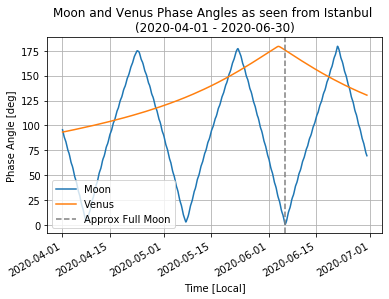

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

# ***** Plot the Moon and Venus illumination percentages *****
time_list = obs_times.to_datetime(timezone=ist_timezone)
plt.plot(time_list, phase_angle_moon, time_list, phase_angle_venus)
plt.grid()

# Add full Moon marker
plt.axvline(full_moon_time.to_datetime(timezone=ist_timezone), color="grey", ls="dashed")

# autoformat the time labels on x-axis
plt.gcf().autofmt_xdate()
# plt.xticks(rotation=90)

plt.title(f"Moon and Venus Phase Angles as seen from Istanbul "
          f"\n({obs_times[0].to_datetime(timezone=ist_timezone).date()}"
          f" - {obs_times[-1].to_datetime(timezone=ist_timezone).date()})")
plt.xlabel("Time [Local]")
plt.ylabel("Phase Angle [deg]")
plt.legend(["Moon", "Venus", "Approx Full Moon"])

plt.show()